# Part A: Supervised Learning

In this section, we will explore created 2 sipervised learning models. One to predict average listing review score, and the other to predict occupancy. Together, these two models will help us understand and predict listing popularity.

I've noticed that there are several columns that are either repeats of each other but are direclty correlated


In [1]:
# Baseline Model
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


In [ ]:
df=pd.read_csv('../data/preprocessed/EDA_DF.csv')
df.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,log_dist_km_airport,source_city_LA,source_city_OAK,source_city_SD,source_city_SF,source_city_nan,listing_age_years,reviews_per_year,bathrooms_per_bedroom,bath/bed
0,2008-10-08,NaN,1.00,1.00,1.0,7.0,7.0,1.0,1.0,Prescott,...,2.542756,0,1,0,0,0,11.156164,6.498760,1.00,1.00
1,2009-03-06,NaN,1.00,0.96,1.0,1.0,2.0,1.0,0.0,Adams Point,...,2.456451,0,1,0,0,0,16.210959,19.406240,1.00,0.00
2,2010-03-25,NaN,0.88,0.88,0.0,2.0,4.0,1.0,0.0,Piedmont Avenue,...,2.607292,0,1,0,0,0,15.252055,9.106541,1.00,0.00
3,2010-05-13,NaN,1.00,0.95,1.0,3.0,4.0,1.0,1.0,Shafter,...,2.648236,0,1,0,0,0,14.186301,3.358290,0.50,0.50
4,2010-03-25,NaN,0.88,0.88,0.0,2.0,4.0,1.0,0.0,Temescal,...,2.646392,0,1,0,0,0,13.052055,0.355820,0.75,0.75


In [3]:
df.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'review_scores_rating', 'instant_bookable', 'reviews_per_month',
       'source_city', 'GEOID', 'area_sqmiles', 'crime_count', 'population',
       'NatWalkInd', 'host_response_time_ord', 'amenities_list',
       'safety_amenities_count', 'convenience_amenities_count',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Sha

In [4]:
linreg_df=df.drop(columns=
['dist_km_downtown', # log distances 
'dist_km_airport', 
'availability_30', 
'availability_60',
'availability_90',
'number_of_reviews', # Could be strongly correlated with review score ratings
'number_of_reviews_ltm',
'number_of_reviews_l30d',
'first_review',
'GEOID',# non numeric,
'latitude',
'longitude',
'beds',
'property_type',
'host_response_time',
'room_type',
'property_type',
'crime_count', 
'population',
'source_city',
'host_listings_count',
'host_since',
'neighbourhood_cleansed',
'amenities',
'has_availability',
'amenities_list',
# Dummy Variable trap
'source_city_nan',
'room_type_Entire home/apt'
]).replace([np.inf, -np.inf], np.nan)

## Base Line Regression Model

In [5]:
categorical_cols=[
    #'host_response_time', 
    'host_has_profile_pic',
    'host_identity_verified',
    #'property_type',
    #'room_type',
    'instant_bookable',
    #'room_type_Entire home/apt',
    #'room_type_Hotel room',
    #'room_type_Private room',
    #'room_type_Shared room',
    #'room_type_nan',
    'is_unique_stay',
    #'source_city_LA',
    #'source_city_OAK',
    #'source_city_SD', 
    #'source_city_SF',
    #'source_city_nan'

]

ordinal_col=['host_response_time_ord']

numeric_cols=[ 
    'host_response_rate',
    'host_acceptance_rate',
    'host_total_listings_count',
    'accommodates',
    'price',
    #beds,
    #baths,
    'minimum_nights',
    'maximum_nights',
    #'review_scores_rating',#target
    'reviews_per_month',
    'area_sqmiles',
    'NatWalkInd',
    'safety_amenities_count',
    'convenience_amenities_count',
    'population_per_sqmile',
    'crime_per_1000',
    'host_years',
    'log_dist_km_downtown',
    'log_dist_km_airport',
    'bath/bed'
]



## Baseline Feature Engineering
Based off the distribution work in then EDA process, There were several features that were extremely skewed or had extreme outliers. My initial instinct was to log transform these features. Furthermore, the target variable of review score ratings was left skewed. this makes linear models for this unrealistic because there is very little variation in the target variable. 

In [6]:
right_skewed_outliers = [
    "host_total_listings_count",
    "price",
    "population_per_sqmile",
    "crime_per_1000"
]

def log_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df
log_transform(linreg_df,right_skewed_outliers)



,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,price,minimum_nights,maximum_nights,...,log_dist_km_downtown,log_dist_km_airport,source_city_LA,source_city_OAK,source_city_SD,source_city_SF,listing_age_years,reviews_per_year,bathrooms_per_bedroom,bath/bed
0,1.00,1.00,1.0,2.079442,1.0,1.0,2,4.836282,1,365,...,1.097442,2.542756,0,1,0,0,11.156164,6.498760,1.00,1.00
1,1.00,0.96,1.0,1.098612,1.0,0.0,2,4.564348,4,29,...,0.906212,2.456451,0,1,0,0,16.210959,19.406240,1.00,0.00
2,0.88,0.88,0.0,1.609438,1.0,0.0,2,4.532599,4,365,...,1.500451,2.607292,0,1,0,0,15.252055,9.106541,1.00,0.00
3,1.00,0.95,1.0,1.609438,1.0,1.0,4,5.525453,5,60,...,1.565652,2.648236,0,1,0,0,14.186301,3.358290,0.50,0.50
4,0.88,0.88,0.0,1.609438,1.0,0.0,2,5.123964,21,180,...,1.489207,2.646392,0,1,0,0,13.052055,0.355820,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52120,1.00,1.00,0.0,1.386294,1.0,1.0,2,4.990433,1,365,...,0.427126,1.515615,0,0,1,0,0.016438,2.951482,1.00,1.00
52121,1.00,0.98,0.0,1.609438,1.0,1.0,2,4.653960,2,15,...,1.765551,1.924414,0,0,1,0,0.016438,1.967655,1.00,1.00
52122,1.00,1.00,0.0,4.499810,1.0,1.0,7,5.017280,2,28,...,0.646359,1.518313,0,0,1,0,0.010959,1.978320,0.50,0.50
52123,1.00,0.92,0.0,1.098612,1.0,1.0,4,5.225747,1,90,...,2.902952,2.710459,0,0,1,0,0.010959,1.978320,0.50,0.50


In [7]:
linreg_df=linreg_df.dropna(subset='review_scores_rating')

X=linreg_df.drop(columns='review_scores_rating')
y=linreg_df['review_scores_rating']
y_log=np.log1p(y)



In [8]:
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
print(non_numeric_cols)

Index([], dtype='object')


In [9]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
   
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", "passthrough", categorical_cols),  
    ("ord", ordinal_pipeline, ordinal_col)])



pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mae(y_test, y_pred))


cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
print("CV R2 Mean:", cv_scores.mean())

R2: -0.1695039631573032
RMSE: 0.4516053273736264
MAE: 0.2096751084338912
CV R2 Mean: -0.03542245544502363


In [10]:
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['model']


num_features = numeric_cols + categorical_cols
ord_features = ordinal_col
feature_names = num_features + ord_features


coefs = model.coef_


summary_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})
summary_df

,Feature,Coefficient
0,host_response_rate,0.082126
1,host_acceptance_rate,-0.007289
2,host_total_listings_count,-0.400531
3,accommodates,-0.081687
4,price,0.472779
5,minimum_nights,0.140378
6,maximum_nights,-0.214661
7,reviews_per_month,1.007378
8,area_sqmiles,-0.143200
9,NatWalkInd,-0.026571


In [11]:
lists=[#'room_type_Entire home/apt',
    'room_type_Hotel room',
    'room_type_Private room',
    'room_type_Shared room',
    'room_type_nan',
    'is_unique_stay',
    'source_city_LA',
    'source_city_OAK',
    'source_city_SD', 
    'source_city_SF'
    #'source_city_nan'
    ]
for i in lists:
    print(linreg_df[i].value_counts())

room_type_Hotel room
0    51822
1      303
Name: count, dtype: int64
room_type_Private room
0    40525
1    11600
Name: count, dtype: int64
room_type_Shared room
0    51864
1      261
Name: count, dtype: int64
room_type_nan
0    52125
Name: count, dtype: int64
is_unique_stay
0    51368
1      757
Name: count, dtype: int64
source_city_LA
1    33385
0    18740
Name: count, dtype: int64
source_city_OAK
0    50257
1     1868
Name: count, dtype: int64
source_city_SD
0    41163
1    10962
Name: count, dtype: int64
source_city_SF
0    46215
1     5910
Name: count, dtype: int64


## Findings
The encoded variables are causing alot of issues but in general, I;m not sure a linear model is the best form to capture the relationship

In [12]:
from sklearn.linear_model import Ridge
ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge())
])

param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

best_ridge = ridge_grid.best_estimator_

y_pred = best_ridge.predict(X_test)

print("Best alpha:", ridge_grid.best_params_)
print("Best CV R2:", ridge_grid.best_score_)
print("Test R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

feature_names = best_ridge.named_steps["preprocessor"].get_feature_names_out()
coefs = best_ridge.named_steps["model"].coef_

summary_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

summary_df

Best alpha: {'model__alpha': 1}
Best CV R2: 0.07821652531379682
Test R2: -0.16472938391122494
RMSE: 0.45068252987595053
MAE: 0.2095745943059565


,Feature,Coefficient
7,num__reviews_per_month,0.969534
4,num__price,0.469476
2,num__host_total_listings_count,-0.401275
6,num__maximum_nights,-0.212580
14,num__host_years,0.178414
8,num__area_sqmiles,-0.132071
5,num__minimum_nights,0.128368
10,num__safety_amenities_count,0.103736
11,num__convenience_amenities_count,0.093475
0,num__host_response_rate,0.082570


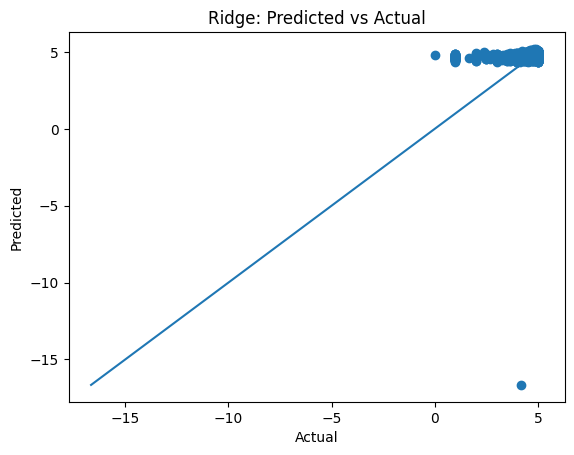

In [13]:
import matplotlib.pyplot as plt
import numpy as np

best_ridge = ridge_grid.best_estimator_

y_pred = best_ridge.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")


min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.title("Ridge: Predicted vs Actual")
plt.show()

In [14]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge())
])

param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train_log)

best_ridge = ridge_grid.best_estimator_

y_pred_log = best_ridge.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

print("Best alpha:", ridge_grid.best_params_)
print("Best CV R2 (log scale):", ridge_grid.best_score_)
print("Test R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

feature_names = best_ridge.named_steps["preprocessor"].get_feature_names_out()
coefs = best_ridge.named_steps["model"].coef_

summary_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

summary_df

Best alpha: {'model__alpha': 1}
Best CV R2 (log scale): 0.06342073010788274
Test R2: 0.053805258807401946
RMSE: 0.40620800019407544
MAE: 0.21830854196975008


,Feature,Coefficient
7,num__reviews_per_month,0.223681
4,num__price,0.088013
2,num__host_total_listings_count,-0.083099
14,num__host_years,0.039993
6,num__maximum_nights,-0.036428
8,num__area_sqmiles,-0.031665
10,num__safety_amenities_count,0.020933
11,num__convenience_amenities_count,0.018789
0,num__host_response_rate,0.017883
5,num__minimum_nights,0.016939


In [15]:
import statsmodels.api as sm
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()


X_processed_df = pd.DataFrame(X_processed, columns=feature_names, index=y.index)

X_processed_df = sm.add_constant(X_processed_df)

ols_model = sm.OLS(y, X_processed_df).fit()

print(ols_model.summary())






                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.079
Model:                              OLS   Adj. R-squared:                  0.079
Method:                   Least Squares   F-statistic:                     194.1
Date:                  Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                          00:55:26   Log-Likelihood:                -24939.
No. Observations:                 52125   AIC:                         4.993e+04
Df Residuals:                     52101   BIC:                         5.014e+04
Df Model:                            23                                         
Covariance Type:              nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [16]:
log_model=sm.OLS(y_log, X_processed_df).fit()

print(ols_model.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.079
Model:                              OLS   Adj. R-squared:                  0.079
Method:                   Least Squares   F-statistic:                     194.1
Date:                  Thu, 26 Feb 2026   Prob (F-statistic):               0.00
Time:                          00:55:26   Log-Likelihood:                -24939.
No. Observations:                 52125   AIC:                         4.993e+04
Df Residuals:                     52101   BIC:                         5.014e+04
Df Model:                            23                                         
Covariance Type:              nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

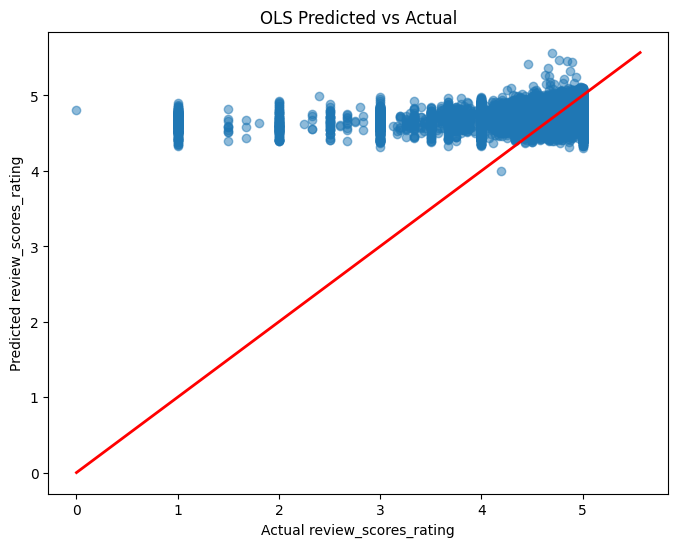

In [17]:
y_pred = ols_model.predict(X_processed_df)

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Actual review_scores_rating")
plt.ylabel("Predicted review_scores_rating")

# 45-degree reference line
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)

plt.title("OLS Predicted vs Actual")
plt.show()

## New Target Variable
Given the lack of variance and the left ske of the review ratings target variable, Divya changed the target variable to reviews per year. This is a right skewed variable so I decided to log transform the variable. 

In [ ]:
import pandas as pd
target_df=pd.read_csv('../data/preprocessed/df_clean.csv')
target_df

,Unnamed: 0,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,host_years,price_per_person,log_dist_km_downtown,log_dist_km_airport,source_city_OAK,source_city_SD,source_city_SF,listing_age_years,reviews_per_year,stratify_col
0,0,1.00,1.00,1.0,7.0,1.0,1.0,37.810130,-122.292660,2,...,16.98,62.500000,1.097442,2.542756,1,0,0,11.156164,6.991650,OAK_Private room
1,1,1.00,0.96,1.0,1.0,1.0,0.0,37.812663,-122.258047,2,...,16.57,47.500000,0.906212,2.456451,1,0,0,16.210959,20.541660,OAK_Entire home/apt
2,2,0.88,0.88,0.0,2.0,1.0,0.0,37.831690,-122.251750,2,...,15.52,46.000000,1.500451,2.607292,1,0,0,15.252055,9.638046,OAK_Entire home/apt
3,3,1.00,0.95,1.0,3.0,1.0,1.0,37.836180,-122.255810,4,...,15.38,62.500000,1.565652,2.648236,1,0,0,14.186301,3.524527,OAK_Entire home/apt
4,4,0.88,0.88,0.0,2.0,1.0,0.0,37.834500,-122.262640,2,...,15.52,83.500000,1.489207,2.646392,1,0,0,13.052055,0.306465,OAK_Entire home/apt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52075,68982,1.00,1.00,0.0,1.0,1.0,1.0,32.716572,-117.157598,2,...,0.18,73.000000,0.427126,1.515615,0,1,0,0.016438,4.000000,SD_Entire home/apt
52076,68997,1.00,0.98,0.0,4.0,1.0,1.0,32.761481,-117.136652,2,...,7.81,52.000000,1.765551,1.924414,0,1,0,0.016438,2.000000,SD_Entire home/apt
52077,69001,1.00,1.00,0.0,30.0,1.0,1.0,32.713751,-117.159809,7,...,5.96,21.428571,0.646359,1.518313,0,1,0,0.010959,2.000000,SD_Entire home/apt
52078,69002,1.00,0.92,0.0,2.0,1.0,1.0,32.836580,-117.276570,4,...,11.05,46.250000,2.902952,2.710459,0,1,0,0.010959,2.000000,SD_Entire home/apt


In [54]:
target_df=target_df.dropna(subset='reviews_per_year')
target_df['reviews_per_year'].describe()

count    52080.000000
mean        16.357637
std         21.452700
min          0.069937
25%          2.170589
50%          8.000000
75%         24.521584
max        811.635860
Name: reviews_per_year, dtype: float64

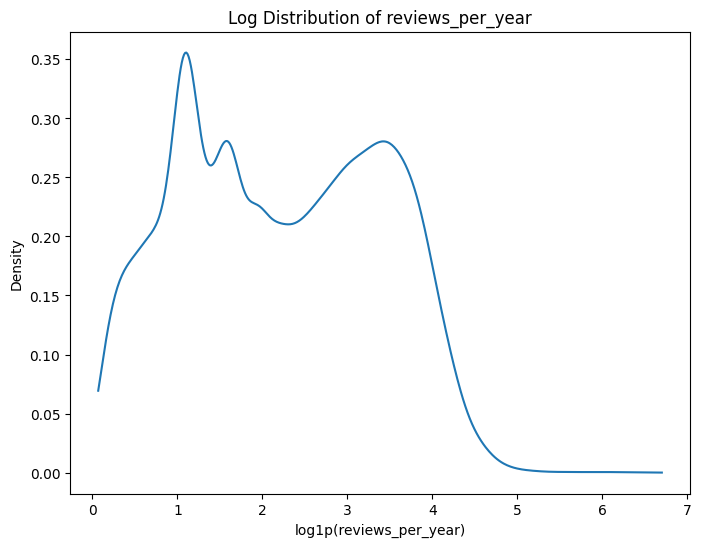

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

column_name='reviews_per_year'
data_log = np.log1p(target_df[column_name])

kde = gaussian_kde(data_log)
x_vals = np.linspace(data_log.min(), data_log.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(8,6))
plt.plot(x_vals, y_vals)
plt.xlabel(f"log1p({column_name})")
plt.ylabel("Density")
plt.title(f"Log Distribution of {column_name}")
plt.show()

In [66]:
y = target_df['reviews_per_year']
y_log = np.log1p(y)

X = target_df.drop(columns=[
    'reviews_per_year',
    'number_of_reviews',
    'review_scores_rating',
    'stratify_col',
    'Unnamed: 0'
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42,
    stratify=target_df['stratify_col']
)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

cv_scores = cross_val_score(model, X, y_log, cv=5, scoring="r2")
print("CV R2 Mean:", cv_scores.mean())
print("mean absolute error:",mae(y_test, y_pred))

R2: 0.3229474627693655
RMSE: 0.9636818065043581
CV R2 Mean: -2.1944328940867086
mean absolute error: 0.7964981890720969


In [69]:
X.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'minimum_nights', 'maximum_nights', 'instant_bookable',
       'area_sqmiles', 'NatWalkInd', 'host_response_time_ord',
       'safety_amenities_count', 'convenience_amenities_count',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'is_unique_stay', 'population_per_sqmile',
       'crime_per_1000', 'host_years', 'price_per_person',
       'log_dist_km_downtown', 'log_dist_km_airport', 'source_city_OAK',
       'source_city_SD', 'source_city_SF', 'listing_age_years'],
      dtype='object')

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

model = LinearRegression()

scoring = {
    "r2": "r2",
    "neg_mse": "neg_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error"
}

cv_results = cross_validate(
    model,
    X,
    y_log,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# R2
r2_mean = cv_results["test_r2"].mean()
r2_std = cv_results["test_r2"].std()


rmse_scores = np.sqrt(-cv_results["test_neg_mse"])
rmse_mean = rmse_scores.mean()
rmse_std = rmse_scores.std()


mae_scores = -cv_results["test_neg_mae"]
mae_mean = mae_scores.mean()
mae_std = mae_scores.std()

print(f"R2: {r2_mean:.4f} ± {r2_std:.4f}")
print(f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
print(f"MAE: {mae_mean:.4f} ± {mae_std:.4f}")

R2: -2.2986 ± 5.0740
RMSE: 1.6400 ± 1.3036
MAE: 1.2329 ± 0.8222


In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

ridge = Ridge()

ridge_param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge_grid = GridSearchCV(
    ridge,
    ridge_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

best_ridge = ridge_grid.best_estimator_

y_pred_ridge = best_ridge.predict(X_test)

print("RIDGE RESULTS")
print("Best alpha:", ridge_grid.best_params_)
print("CV R2 (log scale):", ridge_grid.best_score_)
print("Test R2 (log scale):", r2_score(y_test, y_pred_ridge))
print("RMSE (log scale):", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("MAE (log scale):", mean_absolute_error(y_test, y_pred_ridge))

RIDGE RESULTS
Best alpha: {'alpha': 0.001}
CV R2 (log scale): -1.14626287227336
Test R2 (log scale): 0.3236172037067787
RMSE (log scale): 0.9632050511480545
MAE (log scale): 0.7963731027674034


In [24]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=10000)

lasso_param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1]
}

lasso_grid = GridSearchCV(
    lasso,
    lasso_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

lasso_grid.fit(X_train, y_train)

best_lasso = lasso_grid.best_estimator_

y_pred_lasso = best_lasso.predict(X_test)

print("\nLASSO RESULTS")
print("Best alpha:", lasso_grid.best_params_)
print("CV R2 (log scale):", lasso_grid.best_score_)
print("Test R2 (log scale):", r2_score(y_test, y_pred_lasso))
print("RMSE (log scale):", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("MAE (log scale):", mean_absolute_error(y_test, y_pred_lasso))


LASSO RESULTS
Best alpha: {'alpha': 0.0001}
CV R2 (log scale): -1.1551759217813777
Test R2 (log scale): 0.3234285180535501
RMSE (log scale): 0.9633393909791007
MAE (log scale): 0.7968101392979029


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(max_iter=10000))
])

param_grid = {
    "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1]
}

lasso_grid = GridSearchCV(
    lasso_pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

lasso_grid.fit(X_train, y_train)
print(lasso_grid.best_score_)

0.01566878729081598


## Post PCA Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot  as plt

pca_df=pd.read_csv('../data/preprocessed/final_dataset.csv')
pca_df = pca_df[pca_df['number_of_reviews'] > 0]

/tmp/ipykernel_108/287782804.py:11: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  pca_df=pd.read_csv('/work/data/preprocessed/final_dataset.csv')


In [27]:
drop_cols = [
    # id, urls, text
    
    "id", 
    "listing_url", 
    "scrape_id",
    "last_scraped",
    "source", 
    "picture_url", 
    "last_scraped",
    "calendar_last_scraped",
    "calendar_updated",
    "name",
    "description",
    "neighborhood_overview",
    "host_about",
    "host_id",
    "host_url",
    "host_name",
    "host_location",
    "host_thumbnail_url",
    "host_picture_url",
    "host_neighbourhood",
    "host_verifications",

    # neighborhood
    "neighbourhood",
    "neighbourhood_group_cleansed",

    
   # future looking 
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    
    "minimum_nights_avg_ntm", 
    "maximum_nights_avg_ntm",

    # redundant
    #"host_total_listings_count", -- keeping for clustering
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",

    # review related redundant
    "review_scores_accuracy",
    #"review_scores_cleanliness", -- keeping for clustering
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",

    # others / objects
    "license",
    "bathrooms_text",
    "calendar_updated",
    "calendar_last_scraped",
    "last_review",

    # spatial join related
    "geometry",
    "ALAND", # area of the land in sq mt
    "index_right", # result of spatial join

    # dont know the definitions / redundant
    "availability_eoy",
    "number_of_reviews_ly",
    "estimated_occupancy_l365d",
    "estimated_revenue_l365d",

    # leaks info 
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    #'availability_365', -- keeping for clustering

    # no: of reviews redundant
    'number_of_reviews_ltm',
    'number_of_reviews_l30d',
    #'reviews_per_month' -- keeping for clustering

    # used to create other features, now redundant
    "amenities", # counts are created
    "host_since", # host_years is created 
    "crime_count", # nomalized
    "population", # nomalized
    "price_per_person",  # keeping price instead
    "amenities_list", # already tranformed to counts 
    'host_response_time', # ordinal is created for this
    
    # one hot encoded columns
    'room_type',
    'source_city',
   

    # log transformations are already there
    'dist_km_downtown', #-- keeping for visualization 
    'dist_km_airport', #-- keeping for visualization 

    #'log_dist_km_downtown', 
    #'log_dist_km_airport',
    

    # already calculated in years
    'first_review',

    # location based features - already have log distances
    'GEOID',
    'neighbourhood_cleansed',
    #'latitude', -- keeping for clustering
    #'longitude', -- keep for clustering

   
    'property_type',

    # normlaized by year
    'number_of_reviews', 
    'review_scores_cleanliness',

    # dummy variable trap
    'source_city_LA',
    "source_city_OAK",
    "source_city_SD",
    "source_city_SF",
    'source_city_nan',
    'room_type_Entire home/apt', 
    'room_type_nan',

    # created new
    #'bathrooms', -- keeping for clustering
    #'beds', -- keeping for clustering
    'bathrooms_per_bedroom',

    # location 
    "area_sqmiles",
    "crime_per_1000", # too skewed

# irrelevant
'host_has_profile_pic', 
'host_identity_verified',
'host_total_listings_count', 
]

In [28]:
cols_drop_valid = [col for col in drop_cols if col in pca_df.columns]
pca_df.drop(columns=cols_drop_valid, inplace=True)



In [29]:
pca_df.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_365', 'review_scores_rating',
       'instant_bookable', 'reviews_per_month', 'NatWalkInd',
       'host_response_time_ord', 'safety_amenities_count',
       'convenience_amenities_count', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'is_unique_stay',
       'population_per_sqmile', 'crime_per_sqmile', 'host_years',
       'log_dist_km_downtown', 'log_dist_km_airport', 'listing_age_years',
       'reviews_per_year'],
      dtype='object')

In [30]:
outliers = [
    "host_listings_count",
    "price",
    "population_per_sqmile",
    "crime_per_sqmile"
]

log_transform(pca_df, outliers)

/root/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,room_type_Private room,room_type_Shared room,is_unique_stay,population_per_sqmile,crime_per_sqmile,host_years,log_dist_km_downtown,log_dist_km_airport,listing_age_years,reviews_per_year
0,1.00,1.00,1.0,2.079442,37.810130,-122.292660,2,1.0,1.0,1.0,...,1,0,0,9.063072,7.491118,16.98,1.097442,2.542756,11.156164,6.498760
1,1.00,0.96,1.0,0.693147,37.812663,-122.258047,2,1.0,0.0,1.0,...,0,0,0,10.664501,8.589733,16.57,0.906212,2.456451,16.210959,19.406240
2,0.88,0.88,0.0,1.098612,37.831690,-122.251750,2,1.0,0.0,2.0,...,0,0,0,9.571853,7.827174,15.52,1.500451,2.607292,15.252055,9.106541
3,1.00,0.95,1.0,1.386294,37.836180,-122.255810,4,1.0,2.0,2.0,...,0,0,0,9.499563,7.762690,15.38,1.565652,2.648236,14.186301,3.358290
4,0.88,0.88,0.0,1.098612,37.834500,-122.262640,2,1.5,2.0,2.0,...,0,0,0,9.722490,8.705515,15.52,1.489207,2.646392,13.052055,0.355820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52120,1.00,1.00,0.0,0.693147,32.716572,-117.157598,2,1.0,1.0,2.0,...,0,0,0,9.978269,9.810757,0.18,0.427126,1.515615,0.016438,2.951482
52121,1.00,0.98,0.0,1.609438,32.761481,-117.136652,2,1.0,1.0,1.0,...,0,0,0,9.003795,5.712506,7.81,1.765551,1.924414,0.016438,1.967655
52122,1.00,1.00,0.0,3.433987,32.713751,-117.159809,7,1.0,2.0,3.0,...,0,0,0,9.978269,9.810757,5.96,0.646359,1.518313,0.010959,1.978320
52123,1.00,0.92,0.0,1.098612,32.836580,-117.276570,4,1.0,2.0,2.0,...,0,0,0,9.022103,5.598179,11.05,2.902952,2.710459,0.010959,1.978320


In [31]:
categorical_cols=[
    'host_is_superhost',
    'host_response_time_ord',
    'room_type_Hotel room',
    'room_type_Private room',
    'room_type_Shared room',
    'is_unique_stay'
]

numerical_cols = [
    col for col in pca_df.columns
    if col not in categorical_cols + ['review_scores_rating']
]

In [32]:
X=pca_df.drop(columns='review_scores_rating')
y=pca_df['review_scores_rating']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [86]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

print("Number of components:", X_train_pca.shape[1])

Number of components: 20


In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
import numpy as np

lr = LinearRegression()
lr.fit(X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mae(y_test, y_pred))

R2: -0.1051465458828098
RMSE: 0.4390036618627755
MAE: 0.20909488700156367


In [116]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import numpy as np

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10)),
    ('lr', LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=kf,
    scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
    return_train_score=False
)

print("R2:", np.mean(cv_results['test_r2']))
print("RMSE:", -np.mean(cv_results['test_neg_root_mean_squared_error']))
print("MAE:", -np.mean(cv_results['test_neg_mean_absolute_error']))




R2: 0.0463590496189028
RMSE: 0.3968158575872866
MAE: 0.20597679991998205


In [119]:
print("X_test_pca shape:", X_test_pca.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

X_test_pca shape: (10425, 20)
y_test shape: (10425,)
y_pred shape: (10425,)


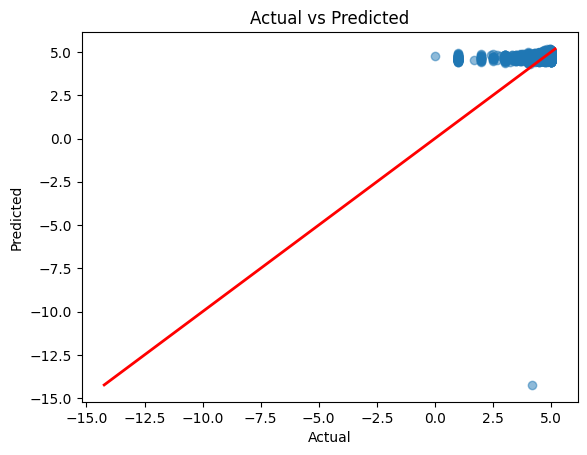

In [122]:
plt.scatter(y_test, y_pred, alpha=0.5)  
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")


min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2)

plt.show()

In [125]:
beta_original = pca.components_.T @ lr.coef_
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": beta_original
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coef_df)

                        Feature  Coefficient
2             host_is_superhost    -0.060529
9                          beds     0.039218
20         room_type_Hotel room     0.036096
13             availability_365    -0.033004
12               maximum_nights    -0.029880
1          host_acceptance_rate     0.026623
16                   NatWalkInd     0.026564
6                  accommodates     0.025543
26                   host_years    -0.022556
25             crime_per_sqmile     0.022261
5                     longitude    -0.017935
17       host_response_time_ord     0.016301
14             instant_bookable     0.014522
24        population_per_sqmile     0.014409
21       room_type_Private room     0.011813
28          log_dist_km_airport    -0.011382
7                     bathrooms    -0.009226
11               minimum_nights    -0.007627
10                        price     0.006073
15            reviews_per_month    -0.005434
23               is_unique_stay    -0.005021
8         

In [47]:
for i in range(X_train_pca.shape[1]):
    pc_name = f"PC{i+1}"
    pc_coef = lr.coef_[i]
    loadings = pca.components_[i, :]  
    
    
    pc_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Feature_Loading": loadings
    }).sort_values(by="Feature_Loading", key=abs, ascending=False)  
    
    print(f"\n{pc_name} (Regression Coefficient: {pc_coef:.3f})")
    print(pc_df)



PC1 (Regression Coefficient: 0.010)
                        Feature  Feature_Loading
8                      bedrooms         0.354934
5                     longitude         0.343469
7                     bathrooms         0.331871
6                  accommodates         0.326120
4                      latitude         0.242189
3           host_listings_count        -0.240970
18       safety_amenities_count        -0.238353
17       host_response_time_ord         0.203474
0            host_response_rate         0.203113
1          host_acceptance_rate         0.202713
19  convenience_amenities_count        -0.202455
21       room_type_Private room         0.201871
23               is_unique_stay        -0.161781
12               maximum_nights         0.161594
15            reviews_per_month        -0.148642
14             instant_bookable         0.136891
10                        price        -0.117322
16                   NatWalkInd         0.115189
20         room_type_Hotel room 

In [50]:
n_pcs = X_train_pca.shape[1]
pc_names = [f"PC{i+1}" for i in range(n_pcs)]


beta_original = pca.components_.T @ lr.coef_


feature_pc_df = pd.DataFrame(index=X_train.columns)


for i in range(n_pcs):
    pc_name = pc_names[i]
   
    feature_pc_df[pc_name + "_contrib"] = pca.components_[i, :] * lr.coef_[i]


feature_pc_df["Total_Contribution"] = beta_original


feature_pc_df = feature_pc_df.reindex(feature_pc_df["Total_Contribution"].abs().sort_values(ascending=False).index)


feature_pc_df = feature_pc_df.reset_index().rename(columns={"index": "Feature"})

feature_pc_df

,Feature,PC1_contrib,PC2_contrib,PC3_contrib,PC4_contrib,PC5_contrib,PC6_contrib,PC7_contrib,PC8_contrib,PC9_contrib,...,PC12_contrib,PC13_contrib,PC14_contrib,PC15_contrib,PC16_contrib,PC17_contrib,PC18_contrib,PC19_contrib,PC20_contrib,Total_Contribution
0,room_type_Hotel room,-0.001032,0.000299,-0.000985,0.021038,0.002599,0.005487,-0.001742,0.003136,-3.011636e-04,...,-0.000321,2.204086e-04,-0.000951,-0.000684,-0.000146,0.019336,-2.874203e-03,-0.000550,-0.000084,0.040148
1,availability_365,0.000856,-0.000582,0.000778,-0.009612,-0.006923,-0.003382,-0.001553,-0.004906,3.737565e-04,...,-0.000508,2.979716e-04,0.001740,-0.000645,-0.000256,-0.001682,-2.851742e-03,0.001444,0.000049,-0.038592
2,maximum_nights,0.001601,-0.000691,0.000203,-0.010301,-0.000381,0.003485,-0.001395,-0.013804,4.917140e-04,...,-0.001339,-1.041315e-04,-0.002893,-0.002140,0.000309,0.002440,1.313607e-03,-0.008773,0.000004,-0.032953
3,NatWalkInd,0.001141,-0.000455,-0.000024,0.008093,0.001471,0.000394,-0.000693,0.024109,6.561572e-04,...,-0.002140,-5.927675e-05,0.000296,0.002216,-0.000556,-0.000994,-1.187045e-03,0.000372,0.000014,0.031432
4,host_is_superhost,-0.000190,-0.000377,-0.000533,-0.014261,-0.005116,-0.000615,-0.004842,0.005277,-2.502985e-04,...,0.001070,8.074944e-05,-0.004888,0.002373,-0.000050,-0.002791,-2.881140e-04,0.000230,-0.000019,-0.024770
5,host_years,0.000509,-0.000595,0.000124,-0.005120,0.002073,0.004513,0.000342,-0.000729,-1.814429e-04,...,0.000132,-1.974987e-05,0.000874,0.000101,0.000121,-0.009995,-1.132750e-02,-0.003833,0.000262,-0.020792
6,population_per_sqmile,0.000997,-0.000659,0.004162,0.021618,0.001179,-0.002060,-0.002207,-0.004885,1.905094e-04,...,0.000550,-1.607318e-06,-0.000095,0.000063,0.000001,-0.001615,-8.522856e-04,0.000034,-0.000018,0.018485
7,instant_bookable,0.001356,-0.000772,0.004286,0.016566,0.000555,-0.003136,-0.001477,-0.004683,2.477587e-04,...,0.000721,-3.242847e-05,-0.000085,0.000057,0.000146,0.003427,-2.360789e-03,-0.000065,0.000010,0.017030
8,accommodates,0.003231,-0.000750,-0.002340,0.003184,0.001449,0.000744,0.000142,-0.007571,-1.389484e-04,...,-0.000266,5.831288e-06,-0.000761,-0.000048,-0.000025,-0.000065,-1.542279e-03,0.020191,-0.000036,0.016187
9,host_response_time_ord,0.002016,0.000020,-0.000824,0.001861,-0.001738,0.000125,0.000070,0.016957,8.892332e-04,...,0.000902,-7.358386e-05,-0.001560,-0.003532,0.000476,-0.003371,-2.028049e-04,0.002799,-0.000042,0.015455


## Ablation analysis

In [110]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('lr', LinearRegression())
])

baseline_cv = cross_validate(
    baseline_pipeline,
    X,
    y,
    cv=kf,
    scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
)

baseline_r2 = np.mean(baseline_cv['test_r2'])
baseline_rmse = -np.mean(baseline_cv['test_neg_root_mean_squared_error'])
baseline_mae = -np.mean(baseline_cv['test_neg_mean_absolute_error'])

print("Baseline")
print("Average R2:", baseline_r2)
print("Average RMSE:", baseline_rmse)
print(" Average MAE:", baseline_mae)


Baseline
R2: 0.6432952950870462
RMSE: 0.2424199086433477
MAE: 0.11528680258025296


In [113]:
baseline_pipeline.fit(X, y)

pca = baseline_pipeline.named_steps['pca']
lr = baseline_pipeline.named_steps['lr']

pc_coefs = lr.coef_
pc_indices = np.argsort(np.abs(pc_coefs))[::-1]

top5_idx = pc_indices[:5]
bottom5_idx = pc_indices[-5:]

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin
class PCARemove(BaseEstimator, TransformerMixin):
    def __init__(self, remove_idx=None, variance=0.95):
        self.remove_idx = remove_idx
        self.variance = variance

    def fit(self, X, y=None):
        self.pca = PCA(n_components=self.variance)
        self.pca.fit(X)
        return self

    def transform(self, X):
        X_pca = self.pca.transform(X)
        if self.remove_idx is not None:
            X_pca = np.delete(X_pca, self.remove_idx, axis=1)
        return X_pca

In [128]:
top5_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCARemove(remove_idx=top5_idx)),
    ('lr', LinearRegression())
])

top5_cv = cross_validate(
    top5_pipeline,
    X,
    y,
    cv=kf,
    scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
)

print("Remove Top 5 PCs")
print("R2:", np.mean(top5_cv['test_r2']))
print("RMSE:", -np.mean(top5_cv['test_neg_root_mean_squared_error']))
print("MAE:", -np.mean(top5_cv['test_neg_mean_absolute_error']))

Remove Top 5 PCs
R2: -0.2558002624922783
RMSE: 0.4463826982213033
MAE: 0.2189219150229978


In [131]:
bottom5_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCARemove(remove_idx=bottom5_idx)),
    ('lr', LinearRegression())
])

bottom5_cv = cross_validate(
    bottom5_pipeline,
    X,
    y,
    cv=kf,
    scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
)

print("Remove Bottom 5 PCs")
print("R2:", np.mean(bottom5_cv['test_r2']))
print("RMSE:", -np.mean(bottom5_cv['test_neg_root_mean_squared_error']))
print("MAE:", -np.mean(bottom5_cv['test_neg_mean_absolute_error']))

Remove Bottom 5 PCs
R2: 0.6313948532886737
RMSE: 0.24646770836715998
MAE: 0.1169444159470121


In [ ]:
# Divya failure analysis code


failure_df = X_test.copy()
errors = np.abs(y_test - xgb_preds)
failure_df['y_true'] = y_test
failure_df['y_pred'] = xgb_preds
failure_df['abs_error'] = errors

top_failures = failure_df.sort_values('abs_error', ascending=False).head(50)
top_failures